# Initial Investigations

looking thru: https://www.midi.org/forum/279-yamaha-bull-dump-data-format,
http://rnhart.net/articles/bulk-dump.htm

In [1]:
from __future__ import print_function, division
import itertools
import re

In [2]:
# numpy imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def hexbyte(x):
    return "{:02X}".format(x)

def binbyte(x):
    return "{:08b}".format(x)

def tohex(by, sep=" "):
    return sep.join(hexbyte(x) for x in by)
def tobin(by, sep=" "):
    return sep.join(binbyte(x) for x in by)

def hexline(by):
    if len(by) <= 24:
        return tohex(by)
    else:
        return tohex(by[:20]) + "..." + tohex(by[-4:])

def takebyn(by, n=8):
    for i in range(0, len(by), n):
        yield by[i:i+n]
        
def itertaken(seq, n):
    itr = iter(seq)
    try:
        while True:
            group = []
            for _ in range(n):
                group.append(next(itr))
            yield group
    except StopIteration:
        if group:
            yield group

def printhex(by, n=8, group=1):
    grouped = ("".join(hexbyte(x) for x in g) for g in takebyn(by, group))
    for x in itertaken(grouped, n):
        print(" ".join(x))


In [4]:
with open('data/syxout.txt') as hexdata:
    lines = [bytearray.fromhex(line.strip()) for line in hexdata]

## Picking at the message structure

In [5]:
for line in lines:
    print(hexline(line))

F0 43 73 7F 44 06 0A 10 00 10 00 00 00 00 1F 00 0A 03 68 03...37 00 3B F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 10 00 00 37 00 03 45 7F...3B 10 0A F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 20 00 55 27 37 42 00 33...41 00 28 F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 30 00 20 00 32 00 00 00...4B 00 56 F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 40 00 00 05 48 4F 01 24...41 00 67 F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 50 00 20 00 33 00 00 00...0B 00 6C F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 60 00 3B 21 01 43 00 01...24 00 4D F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 70 00 29 2F 2F 51 44 01...00 00 1C F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 00 00 00 46 43 02 4A 42...40 22 21 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 10 00 00 02 12 1D 42 29...43 00 54 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 20 00 45 02 3E 00 00 37...4F 00 6D F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 30 00 00 06 48 56 00 4C...03 08 27 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 40 00 10 58 00 02 60 02...01 08 37 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 50

In [6]:
lb = lines[0]
ls = lines[-4]

### Header
sysex-flag/manufacturer/device/data type header: `F0 43 73 7F 44 06`. 

If this is using the same conventions as the PSR-225, then `0A` is for song data and `09` is for the one-touch panel bank

In [7]:
tohex(lb[:7])

'F0 43 73 7F 44 06 0A'

### 'SS' Size bytes. 

There appear to be four of them. At the EOS this is '00 01 00 01'
the longest messages have this as '10 00 10 00', the last message before EOS has this as '08 68 08 68'.


It appears to be two repeated
 (at least, in the case of the 0A. The 09 data, with only one message, appears to be different again.)

In [8]:
tohex(lb[7:11])

'10 00 10 00'

### three 'ZZ' running total bytes. 

At the EOS this is '7F 7F 7F', then immediately followed by the end F7.


In [9]:
tohex(lb[11:14])

'00 00 00'

### the 'KK' checksum and end-of-message flag F7.

In [10]:
tohex(lb[-2:])


'3B F7'

This should, and I say *should*, be of a similar format, so...
If this works, sum of SS SS SS to KK inclusive should be 0 (mod 128).

In [11]:
print([sum(line[7:-1]) % 128 for line in lines])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 127]


It worked, except for the two end-of-section messages, which don't have the checksum byte.

### Checking the Numbers

In [12]:
def unpackseven(by):
    # Ignore the first bit, which is always zero.
    # The most signifcant bit comes first
    value = 0
    for i, b in enumerate(reversed(by)):
        value |= b << (i*7)
    return value

def unpacksevenhex(hexstring):
    return "{:#x}".format(unpackseven(bytearray.fromhex(hexstring)))

In [13]:
unpacksevenhex('10 00')

'0x800'

In [14]:
len(lb[14:-2])

2048

0x800, or 2048 bytes of encoded data seems to be the maximum.
the ZZ bytes appear to increment by this amount.

that penultimate message should be 0x468, or 1128, bytes...

In [15]:
unpacksevenhex('08 68')

'0x468'

In [16]:
unpackseven(ls[7:9]) == len(ls[14:-2])

True

In [17]:
len(ls[14:-2])

1128

Yep.

## What's all that data?
Instead encoding one byte to two by nybble, with 0F 07 == 7F like in the [PSR-225](http://rnhart.net/articles/bulk-dump.htm), it seems that the 'payload' data uses all seven available bits, which could mean several things.

In [18]:
payloads = [line[14:-2] for line in lines[:-3]]

In [19]:
payload = bytearray().join(payloads)

From staring at the 'payload' in a hex editor, I have recognised some patterns. I think that every 8th byte is some sort of 'parity' byte or something. Ignoring these bytes you can see the ascii for 'YAMAHA' and 'MTrk' and 'PresetStyle\x00'. So that's a start.

In [20]:
len(payload)/8

9613.0

### What Is That Eighth Byte?

In [21]:
pays = np.array(payload).reshape((9613,8))

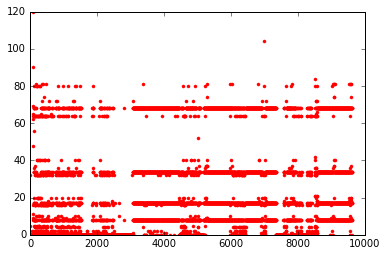

In [22]:
plt.plot(pays[:,7], 'r.')

In [23]:
np.asarray(np.unique(pays[:,7], return_counts=True)).T

array([[   0, 3084],
       [   1,  120],
       [   2,  122],
       [   4,   96],
       [   5,   28],
       [   8, 1468],
       [   9,   18],
       [  10,   25],
       [  11,    1],
       [  16,   93],
       [  17, 1348],
       [  18,   19],
       [  20,   40],
       [  21,    4],
       [  32,  126],
       [  33,    1],
       [  34, 1354],
       [  36,   17],
       [  37,   12],
       [  40,   34],
       [  42,    1],
       [  48,    1],
       [  52,    1],
       [  56,    1],
       [  62,    1],
       [  64,  126],
       [  65,    4],
       [  66,    1],
       [  68, 1398],
       [  69,    1],
       [  72,   16],
       [  74,    5],
       [  80,   25],
       [  81,   18],
       [  84,    1],
       [  90,    1],
       [ 104,    1],
       [ 120,    1]])

In [24]:
tobin(pays[pays[:,7]==65,:][2])

'01110000 00000101 01111110 01111111 00001001 00000001 01110111 01000001'

In [25]:
tobin(np.unique(pays[:,7]))

'00000000 00000001 00000010 00000100 00000101 00001000 00001001 00001010 00001011 00010000 00010001 00010010 00010100 00010101 00100000 00100001 00100010 00100100 00100101 00101000 00101010 00110000 00110100 00111000 00111110 01000000 01000001 01000010 01000100 01000101 01001000 01001010 01010000 01010001 01010100 01011010 01101000 01111000'

### The Solution

If I had to squeeze 8 bits down into seven, how would I do it?
Maybe, we take each of the seven bits of the eighth byte and stick them in front of the previous seven?

In [26]:
def reconstitute(by):
    blob = by[:7]
    for i in range(7):
        bitmask = 0b01000000 >> i
        blob[i] = blob[i] | ((by[7] & bitmask) << i+1)
    return blob

def reconstitute_all(by):
    return bytearray().join(reconstitute(g) for g in takebyn(by, 8))

In [27]:
payload8 = reconstitute_all(payload)

Note that whenever an F0 occurs it is always followed by F7:

In [28]:
map(tohex, re.findall(r'\xF0[\x00-\x7F]*[\x80-\xFF]', payload8))

['F0 09 43 10 4C 02 01 00 01 11 F7',
 'F0 09 43 10 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 11 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 12 4C 02 01 00 01 10 F7',
 'F0 09 43 12 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 10 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 12 4C 02 01 00 01 10 F7',
 'F0 09 43 12 4C 02 01 20 42 11 F7',
 'F0 09 43 10 4C 02 01 00 01 10 F7',
 'F0 09 43 10 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 10 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 10 4C 02 01 00 01 10 F7',
 'F0 09 43 10 4C 02 01 20 42 11 F7',
 'F0 09 43 11 4C 02 01 00 01 10 F7',
 'F0 09 43 11 4C 02 01 20 42 11 F7',
 'F0 09 43 13 4C 02 01 00 01 10 F7',
 'F0 09 43 13 4C 02 01 20 42 11 F7',
 'F0 09 43 11 4C 02 01 00 01 11 F7',
 'F0 09 43 11 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 11 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 1

It sure looks like there are some system exclusive messages in here! (Stored in MIDI file format, of course.)

Leafing through the manual (pg 110-111), it seems these are the GM System / volume / tuning / reverb / chorus events

And here are some style meta-events:

In [29]:
map(tohex, re.findall(r'\x43\x76\x1A\x04.{2}', payload8))

['43 76 1A 04 00 5B',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 87',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00']

## Figuring Out The File Structure

Assuming the file structure is similar to the [PSR-225's block system](http://rnhart.net/articles/bulk-dump.htm)...

In [30]:
len(payload8)

67291

It looks like there are 67291 bytes of decoded data instead of the 66766 bytes in the PSR-225.

In [31]:
printhex(payload8[:0x15a], 16)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E
00 00 19 00 01 00 00 01 7F 00 0A 00 0F 00 13 00
16 00 18 00 1A 00 1B 00 1C 00 1D 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 05 00
08 00 0B 00 0D 00 0F 00 11 00 13 00 15 00 16 00
17 00 17 00 18 00 18 00 19 00 1A 00 1A 00 1B 00
1B 00 1B 00 1C 00 1C 00 1C 00 1D 00 1D 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 19 00 19 00 19 00 19 00 19 00 18 00 18 00
18 00 17 00 17 00 16 00 16 00 15 00 15 00 14 00
14 00 13 00 13 00 12 00 12 00 11 00 11 00 10 00
10 00 0F 00 0E 00 0D 00 0C 00 0B 00 0A 00 19 00
19 00 14 00 14 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 0

I have no idea what the first 0x15A bytes are. Maybe it's a bunch of 16-bit numbers?

In [32]:
printhex(payload8[0x15a:0x162])

64 02 BC 21 07 1F 05 0F


The DGX-505 has 5 UserSongs compared to the PSR-225's three. Each user song has five normal tracks and one chord/accompaniment track (track A).

At the time this dump was gathered, all five songs had data, and used the following tracks as displayed on the panel:
1. `1 _ _ _ _ A`
2. `1 2 3 _ _ _`
3. `1 2 3 4 5 _`
4. `1 _ 3 _ _ _`
5. `1 2 3 4 _ _`

In [33]:
track_bitfields = slice(0x15d, 0x162)

print(tobin(payload8[track_bitfields], '\n'))

00100001
00000111
00011111
00000101
00001111


The five bytes from 0x15d to 0x161 appear to correspond to the five usersongs, with the low 5 bits of each representing the active tracks on each (from least to most significant bit, track 1 - 2 - 3 - 4 - 5 - A).

This corresponds to offsets 0x00001-0x00003 on the PSR-225.

Still don't know what `64 02 BC` is, though.

In [34]:
printhex(payload8[0x162:0x1f3], 16)

00 00 00 00 00 00 00 00 27 00 00 00 0B 00 00 00
25 00 00 00 08 00 00 00 11 00 00 00 27 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
25 00 00 00 0B 00 00 00 0B 00 00 00 0B 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 12 00 00 00
1F 00 00 00 21 00 00 00 25 00 00 00 25 00 00 00
00 00 00 00 08 00 00 00 00 00 00 00 08 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 11 00 00 00
10 00 00 00 10 00 00 00 11 00 00 00 00 00 00 00
00


Following are some bytes of more unknown stuff which could be 32 bit integers?

In [35]:
printhex(payload8[0x1f3:0x22f], 12)
payload8[0x1f3:0x22f].decode('ascii')

50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00


u'PresetStyle\x00PresetStyle\x00PresetStyle\x00PresetStyle\x00PresetStyle\x00'

... followed by five repeats of ascii 'PresetStyle' and `00`. The PSR-225 only has three of these (starting from 0x00007), so this has probably got something to do with each song.

In [36]:
beginning_blocks = slice(0x22f,0x24d)

printhex(payload8[beginning_blocks], 6)

01 FF FF FF FF 02
19 12 14 FF FF 13
43 47 7B 82 51 44
0B FF 07 FF FF 08
0D 0F 0A 11 FF 0C


Immediately following that, we have what appears to be the 30 bytes from 0x22f through 0x24c indicating the beginning blocks, corresponding to 0x0002B-0x0003F on the PSR-225.

Each group of six bytes corresponds to a usersong in order, and each byte corresponds to a track, from 1-5, followed by the *time track* with the tempo, SysEx, etc. (Compare with the PSR-225, which has 6+1 tracks for each of its 3 songs and therefore needs 21 (=0x15) bytes total.)

Blocks are numbered 0x01 to 0x82 and `FF` indicates that the track is not in use.

In [37]:
next_blocks = slice(0x24d,0x2cf)

printhex(payload8[next_blocks], 16)

04 03 FF 05 06 FF 09 FF FF FF FF FF 0E FF 10 FF
FF 17 FF 15 16 1B 18 FF 1A FF FF 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 45 FF 46 FF 48 49 4A 4B 60 4D 4E 4F 50 58
52 53 54 55 56 57 FF 59 5A 5B 5C 5D FF 00 00 61
62 63 7A 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 FF 7C 7D 7E 7F 80 81
FF 4C


Running from 0x24d to 0x2ce is the table of 0x82 (=130) next blocks, corresponding to 0x00040-0x000C1 on the PSR-225.

`00` indicates unused blocks, `FF` indicates final blocks.

In [38]:
printhex(payload8[0x2cf:0x2d5])
payload8[0x2cf:0x2d5].decode('ascii')

50 4B 30 30 30 31


u'PK0001'

At 0x2cf, we find 'PK0001', which corresponds to the PSR-225's 'PK9801' at 0x000C2, and marks the beginning of the block data at 0x2d5.

In [39]:
printhex(payload8[0x106d5:])
payload8[0x106d5:].decode('ascii')

50 4B 30 30 30 31


u'PK0001'

The final six bytes, spelling 'PK0001' again from 0x106d5 to 0x106da, mark the end of the block data and correspond to 0x104C8-0x104CD on the PSR-225.

In [40]:
(0x106d5-0x2d5)/0x82

512.0

Like the PSR-225, the blocks are 0x200 = 512 bytes in size.

Block 0x01 begins at offset 0x2d5:

In [41]:
printhex(payload8[0x2d5:0x2d5+8])
payload8[0x2d5:0x2d5+8]

4D 54 72 6B 00 00 07 C2


bytearray(b'MTrk\x00\x00\x07\xc2')

And we can see the start of an MTrk chunk.

To calculate the start each block we can use a simple formula
```
offset(n) = 0x2d5 + (0x200 * (n-1))
```
or, to simplify, 
```
offset(n) = 0xd5 + (0x200 * n)
```


In [42]:
def chunk_offset(n):
    if 0x01 <= n <= 0x82:
        return 0xd5 + (0x200*n)
    else:
        raise ValueError("Invalid chunk", n)

In [43]:
def block_peek(n, length=4):
    offset = chunk_offset(n)
    return payload8[offset:offset+length]

def print_block_peek(n):
    bits = block_peek(n)
    print(u"Block 0x{:02x} at 0x{:05x}: {} - {}".format(n, chunk_offset(n), tohex(bits), 
                                                        bits.decode('ascii', 'replace')))

track_blocks = [x for x in payload8[beginning_blocks] if x != 0xFF]

for n in track_blocks:
    print_block_peek(n)    

Block 0x01 at 0x002d5: 4D 54 72 6B - MTrk
Block 0x02 at 0x004d5: 4D 54 72 6B - MTrk
Block 0x19 at 0x032d5: 4D 54 72 6B - MTrk
Block 0x12 at 0x024d5: 4D 54 72 6B - MTrk
Block 0x14 at 0x028d5: 4D 54 72 6B - MTrk
Block 0x13 at 0x026d5: 4D 54 72 6B - MTrk
Block 0x43 at 0x086d5: 4D 54 72 6B - MTrk
Block 0x47 at 0x08ed5: 4D 54 72 6B - MTrk
Block 0x7b at 0x0f6d5: 4D 54 72 6B - MTrk
Block 0x82 at 0x104d5: 4D 54 72 6B - MTrk
Block 0x51 at 0x0a2d5: 4D 54 72 6B - MTrk
Block 0x44 at 0x088d5: 4D 54 72 6B - MTrk
Block 0x0b at 0x016d5: 4D 54 72 6B - MTrk
Block 0x07 at 0x00ed5: 4D 54 72 6B - MTrk
Block 0x08 at 0x010d5: 4D 54 72 6B - MTrk
Block 0x0d at 0x01ad5: 4D 54 72 6B - MTrk
Block 0x0f at 0x01ed5: 4D 54 72 6B - MTrk
Block 0x0a at 0x014d5: 4D 54 72 6B - MTrk
Block 0x11 at 0x022d5: 4D 54 72 6B - MTrk
Block 0x0c at 0x018d5: 4D 54 72 6B - MTrk


We can see that the blocks marked as the beginning blocks for each track do, indeed, contain the start of the tracks.

In [44]:
print_block_peek(0x5e)

Block 0x5e at 0x0bcd5: 4D 54 72 6B - MTrk


We can also see that some blocks have data left over from previous recordings.

### The Remainder
There are two regions left unexplained:

In [45]:
printhex(payload8[:0x15d], 16)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E
00 00 19 00 01 00 00 01 7F 00 0A 00 0F 00 13 00
16 00 18 00 1A 00 1B 00 1C 00 1D 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 05 00
08 00 0B 00 0D 00 0F 00 11 00 13 00 15 00 16 00
17 00 17 00 18 00 18 00 19 00 1A 00 1A 00 1B 00
1B 00 1B 00 1C 00 1C 00 1C 00 1D 00 1D 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 19 00 19 00 19 00 19 00 19 00 18 00 18 00
18 00 17 00 17 00 16 00 16 00 15 00 15 00 14 00
14 00 13 00 13 00 12 00 12 00 11 00 11 00 10 00
10 00 0F 00 0E 00 0D 00 0C 00 0B 00 0A 00 19 00
19 00 14 00 14 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 0

In [46]:
printhex(payload8[0x162:0x1f3], 16)

00 00 00 00 00 00 00 00 27 00 00 00 0B 00 00 00
25 00 00 00 08 00 00 00 11 00 00 00 27 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
25 00 00 00 0B 00 00 00 0B 00 00 00 0B 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 12 00 00 00
1F 00 00 00 21 00 00 00 25 00 00 00 25 00 00 00
00 00 00 00 08 00 00 00 00 00 00 00 08 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 11 00 00 00
10 00 00 00 10 00 00 00 11 00 00 00 00 00 00 00
00


We've accounted for pretty much everything found in the PSR-225's song dump format, except for the very first byte, offset 0x00000, which is supposed to be a bitfield for the songs in use. If the same pattern is used for the DGX-505, then we should expect to see a `00011111` or `1F` byte somewhere, as all five songs were in use.
The very first byte, offset 0x0, is, in fact, `1F`, so that might just be it (I'll have to delete one of the songs to check).

There's also one feature 'Step Recording' (offset 0x0004-0x0006 on PSR-225) the DGX-505 doesn't have. If the (abscence of) step-recorded tracks was noted directly after the normal tracks, this would account for five `00` bytes directly after the normal tracks at 0x162, and the rest lines up rather nicely as a bunch of 32 bit numbers...


In [47]:
def unpackeight(by):
    # big-endian.
    total = 0
    for i, b in enumerate(reversed(by)):
        total |= b << (i*8)
    return total

def unpackwords(by, n=2):
    # probably not the way to do it, but eh.
    return [unpackeight(x) for x in takebyn(by, n)]

<Container object of 36 artists>

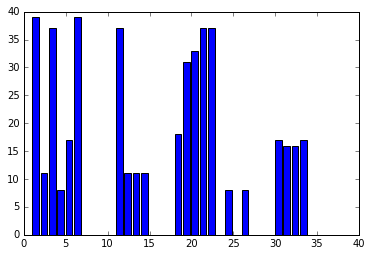

In [48]:
mystery2 = unpackwords(payload8[0x163:0x1f3], 4)
plt.bar(np.arange(len(mystery2)), mystery2)

There's definitely a pattern:

In [49]:
print(tobin(payload8[0x15d:0x162], '\n')) #track_bitfields
print('---')
printhex(payload8[0x162:0x167])
print('---')
printhex(payload8[0x167:0x17b],1,4)
print('---')
printhex(payload8[0x17b:0x1f3],6,4)

00100001
00000111
00011111
00000101
00001111
---
00 00 00 00 00
---
00000027
0000000B
00000025
00000008
00000011
---
00000027 00000000 00000000 00000000 00000000 00000025
0000000B 0000000B 0000000B 00000000 00000000 00000000
00000012 0000001F 00000021 00000025 00000025 00000000
00000008 00000000 00000008 00000000 00000000 00000000
00000011 00000010 00000010 00000011 00000000 00000000


It looks like after the track-active bitfields comes five zero bytes, then five 32-bit numbers that seem to correspond to the five songs, then 30 32-bit numbers that correspond to the tracks on the songs, with values of `00000000` for inactive tracks and other numbers (lengths?) for the active tracks. The five numbers seem to be the largest (longest?) value of the tracks for the corresponding song. Looking through the values, they seem to be roughly the duration of the tracks, in measures.

In [50]:
printhex(payload8[beginning_blocks], 6)

01 FF FF FF FF 02
19 12 14 FF FF 13
43 47 7B 82 51 44
0B FF 07 FF FF 08
0D 0F 0A 11 FF 0C


### The Final Mystery Region

In [51]:
printhex(payload8[:0x15d], 16)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E
00 00 19 00 01 00 00 01 7F 00 0A 00 0F 00 13 00
16 00 18 00 1A 00 1B 00 1C 00 1D 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 05 00
08 00 0B 00 0D 00 0F 00 11 00 13 00 15 00 16 00
17 00 17 00 18 00 18 00 19 00 1A 00 1A 00 1B 00
1B 00 1B 00 1C 00 1C 00 1C 00 1D 00 1D 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 19 00 19 00 19 00 19 00 19 00 18 00 18 00
18 00 17 00 17 00 16 00 16 00 15 00 15 00 14 00
14 00 13 00 13 00 12 00 12 00 11 00 11 00 10 00
10 00 0F 00 0E 00 0D 00 0C 00 0B 00 0A 00 19 00
19 00 14 00 14 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 0

Let's describe some patterns.

From offset 0x0 to 0x18, there's a bunch of bytes. 0x0 may be the song-usage-bitfield thing.

In [52]:
printhex(payload8[:0x19], 16)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E
00 00 19 00 01 00 00 01 7F


From 0x19 to 0x11c, we get 320 bytes of some increasing and decreasing patterns

In [53]:
printhex(payload8[0x19:0x159], 16)

00 0A 00 0F 00 13 00 16 00 18 00 1A 00 1B 00 1C
00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 05 00 08 00 0B 00 0D 00 0F 00 11
00 13 00 15 00 16 00 17 00 17 00 18 00 18 00 19
00 1A 00 1A 00 1B 00 1B 00 1B 00 1C 00 1C 00 1C
00 1D 00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 19 00 19 00 19 00 19
00 19 00 18 00 18 00 18 00 17 00 17 00 16 00 16
00 15 00 15 00 14 00 14 00 13 00 13 00 12 00 12
00 11 00 11 00 10 00 10 00 0F 00 0E 00 0D 00 0C
00 0B 00 0A 00 19 00 19 00 14 00 14 00 0F 00 0F
00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F
00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F
00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F


And then four more bytes of whatever. I'm baffled, really.

In [54]:
printhex(payload8[0x159:0x15d], 16)

00 64 02 BC


In [55]:
mystery_region = payload8[0x019:0x159]

<Container object of 160 artists>

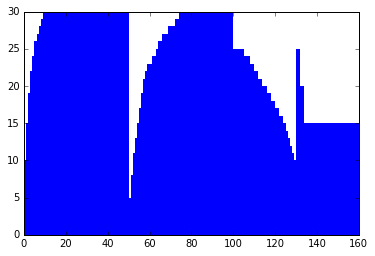

In [56]:
mystery_numbers = unpackwords(mystery_region)
plt.bar(np.arange(160), mystery_numbers, width=1, linewidth=0)

Staring at this, we can see four regions that run from indexes 0-49, 50-99, 100-129 and 130-159. Note that there are 160 numbers here, and 130 blocks in the file system, and 30 tracks. I'm guessing that this has something to do with the blocks just by the numbers here, but I don't know what. Probably some internal file system thing

In [57]:
printhex(mystery_numbers[:-30], 10)
print()
printhex(payload8[next_blocks], 10)

0A 0F 13 16 18 1A 1B 1C 1D 1E
1E 1E 1E 1E 1E 1E 1E 1E 1E 1E
1E 1E 1E 1E 1E 1E 1E 1E 1E 1E
1E 1E 1E 1E 1E 1E 1E 1E 1E 1E
1E 1E 1E 1E 1E 1E 1E 1E 1E 1E
05 08 0B 0D 0F 11 13 15 16 17
17 18 18 19 1A 1A 1B 1B 1B 1C
1C 1C 1D 1D 1E 1E 1E 1E 1E 1E
1E 1E 1E 1E 1E 1E 1E 1E 1E 1E
1E 1E 1E 1E 1E 1E 1E 1E 1E 1E
19 19 19 19 19 18 18 18 17 17
16 16 15 15 14 14 13 13 12 12
11 11 10 10 0F 0E 0D 0C 0B 0A

04 03 FF 05 06 FF 09 FF FF FF
FF FF 0E FF 10 FF FF 17 FF 15
16 1B 18 FF 1A FF FF 00 00 00
00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 45 FF 46 FF
48 49 4A 4B 60 4D 4E 4F 50 58
52 53 54 55 56 57 FF 59 5A 5B
5C 5D FF 00 00 61 62 63 7A 00
00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00
00 FF 7C 7D 7E 7F 80 81 FF 4C


And that still doesn't explain 0x0-0x18, 0x159-0x15c. More experimentation required.

In [58]:
printhex(payload8[0x0:0x19], 32)
printhex(payload8[0x159:0x15d])

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E 00 00 19 00 01 00 00 01 7F
00 64 02 BC


### More Experimentation

I deleted User Song 4 and saved a new dump. The only difference is the first message.

In [59]:
!diff -y --width=100  --suppress-common-lines data/syxout.txt data/syxout1.txt

F0 43 73 7F 44 06 0A 10 00 10 00 00 00 00 1F  |	F0 43 73 7F 44 06 0A 10 00 10 00 00 00 00 17 


In [60]:
with open('data/syxout1.txt') as newdump:
    newdumpline = bytearray.fromhex(newdump.readline().strip())
newpayload8 = reconstitute_all(newdumpline[14:-2])

In [61]:
printhex(payload8[:0x19], 32)
printhex(newpayload8[:0x19], 32)
print(binbyte(payload8[0]))
print(binbyte(newpayload8[0]))

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E 00 00 19 00 01 00 00 01 7F
17 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E 00 00 19 00 01 00 00 01 7F
00011111
00010111


The beginning mystery bytes are the same, except for the first byte, which does indeed seem to be the song usage bitfield, with the least significant bit = user song 1 etc.

In [62]:
payload8[0x19:0x15d] == newpayload8[0x19:0x15d]

True

The mystery region is the same for both files.

In [63]:
print(tobin(newpayload8[0x15d:0x162], '\n')) #track_bitfields
print('---')
printhex(newpayload8[0x162:0x167])
print('---')
printhex(newpayload8[0x167:0x17b],1,4)
print('---')
printhex(newpayload8[0x17b:0x1f3],6,4)

00100001
00000111
00011111
00000000
00001111
---
00 00 00 00 00
---
00000027
0000000B
00000025
00000000
00000011
---
00000027 00000000 00000000 00000000 00000000 00000025
0000000B 0000000B 0000000B 00000000 00000000 00000000
00000012 0000001F 00000021 00000025 00000025 00000000
00000000 00000000 00000000 00000000 00000000 00000000
00000011 00000010 00000010 00000011 00000000 00000000


Song 4 is not in use anymore, neither should its tracks be. Their durations are all zero as well.

In [64]:
printhex(newpayload8[beginning_blocks], 6)
print('---')
printhex(newpayload8[next_blocks], 16)

01 FF FF FF FF 02
19 12 14 FF FF 13
43 47 7B 82 51 44
FF FF FF FF FF FF
0D 0F 0A 11 FF 0C
---
04 03 FF 05 06 FF 00 00 00 FF 00 FF 0E FF 10 FF
FF 17 FF 15 16 1B 18 FF 1A FF FF 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 45 FF 46 FF 48 49 4A 4B 60 4D 4E 4F 50 58
52 53 54 55 56 57 FF 59 5A 5B 5C 5D FF 00 00 61
62 63 7A 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 FF 7C 7D 7E 7F 80 81
FF 4C


Blocks 07, 08, 09 and 0B have been marked empty for reuse.

In [65]:
payload8[0x2cf:0x700] == newpayload8[0x2cf:]

True

The rest of the data is the same.

## Registration Memory, a.k.a. One Touch Settings

Let's look at the final two messages. In the PSR-225, the one-touch settings are sent first, but the DGX-505 sends 'em last.

In [66]:
for line in lines[-2:]:
    print(hexline(line))

F0 43 73 7F 44 06 09 06 30 06 2E 00 00 00 50 53 52 03 01 00...00 00 30 F7
F0 43 73 7F 44 06 09 00 01 00 01 7F 7F 7F F7


Assuming the messages are of roughly the same format, we have:

| field | bytes | content |
|-------|-------|---------|
|Header | `F0 43 73 7F 44 06` | Manufacturer/Device/etc|
|Section type  | `09` | (one-touch settings)|
|Size??   | `06 30 06 2E`   | Different format? |
|Running total | `00 00 00` | First (and only) message, so zero |
|Data     | `50 53 52 03 01 00...00 00` | payload data|
|Checksum | `30` | We checked this earlier|
|End tag  | `F7` |  |

So what's with `06 30 06 2E`?


In [67]:
otsline = lines[-2]
otspayload = otsline[14:-2]

In [68]:
unpackseven(otsline[7:9])

816

In [69]:
unpackseven(otsline[9:11])

814

In [70]:
len(otspayload)

816

In [71]:
otspayload8 = reconstitute_all(otspayload)

In [72]:
len(otspayload8)

714

In [73]:
hexline(otspayload8)

'50 53 52 03 01 00 00 39 39 05 64 00 3B 00 60 40 28 00 00 00...52 03 00 00'

The PSR-225 had 1576 encoded bytes (788 bytes decoded) of OTS data. The DGX-505 has 816 encoded bytes (714 bytes decoded), but the two length values differ by two, `06 30` (=816) and `06 2E` (=814).

The PSR-225 has 4 buttons × 4 banks = 16 settings, each using 0x31 = 49 bytes. The remaining 4 bytes are bitfields for the active banks on each button.

The DGX-505 has 2 buttons × 8 banks = 16 settings, and has 714 bytes to store it in, which is not a nice number to work with. Maybe the two different length values mean something. Perhaps there are empty bytes at the end that were included so the 7-bit encoding would work. When the dump was taken, all 16 settings were in use, so maybe we should see two `FF` bytes?

In [74]:
print(tohex(otspayload8[:4]))
print(tohex(otspayload8[-6:]))

50 53 52 03
50 53 52 03 00 00


The data begins with `50 53 52 03` and ends with `50 53 52 03 00 00`. Perhaps those two extra bytes are the reason for the differing sizes. (As an aside, `50 53 52` is ASCII for 'PSR', but the PSR-225 doesn't have them.)

Disregarding these ten bytes for now leaves us with 704 bytes which divide cleanly into 16 groups of 44. 

In [75]:
otsgroups = list(takebyn(otspayload8[4:-6], 44))
for group in otsgroups:
    print(hexline(group))

01 00 00 39 39 05 64 00 3B 00 60 40 28 00 00 00 2D 00 64 40...00 40 00 00
01 87 00 36 36 05 64 01 67 00 68 40 1C 00 00 00 35 01 72 40...00 40 00 00
01 3D 00 36 36 05 64 00 54 FF 6E 40 22 00 7F 00 36 00 7F 40...00 40 00 00
01 00 00 36 36 05 64 00 59 00 50 40 28 00 00 00 2D 00 64 40...00 40 00 00
01 FF FF 39 39 FF FF 00 34 00 7F 40 28 00 00 00 2D 00 64 40...00 40 00 00
01 00 00 39 39 05 64 00 D3 00 68 40 1C 00 00 00 2D 00 64 40...00 40 00 00
01 87 00 36 36 05 64 00 41 FF 5E 40 2E 00 7F 00 35 01 72 40...00 40 00 00
01 87 01 39 39 05 64 00 34 00 7F 40 28 00 7F 00 34 00 64 40...00 40 00 00
01 FF FF 36 36 FF FF 00 00 00 6E 40 14 00 00 00 2D 00 64 40...00 40 00 00
01 00 00 36 36 05 64 01 4F 00 68 40 1C 00 00 00 2D 00 64 40...00 40 00 00
01 0F 00 37 37 05 64 00 6D 00 70 40 28 22 00 00 06 00 64 40...00 40 00 00
01 00 00 36 36 05 64 00 35 00 56 40 28 00 00 00 2D 00 64 40...00 40 00 00
01 00 00 39 39 05 64 01 6F FF 7F 40 1C 00 7F 00 35 00 64 40...00 40 00 00
01 00 00 39 39 05 64 00 A1 00 68 40 1C

Like the PSR-225, the settings are stored by button and then by bank.

### Decoding the Format

According to the manual (page 68), the following settings can be saved:
- Style (when using style features):
    - Style number
    - Auto accompaniment (ON/OFF)
    - Split Point
    - Style Volume
    - Tempo
- Voice:
    - Main Voice:
        - Voice Number
        - Volume
        - Octave
        - Pan
        - Reverb send level
        - Chorus send level
    - Dual Voice:
        - ON/OFF
        - ... and the same settings as for Main Voice
    - Split Voice:
        - ON/OFF
        - ... and the same settings as for Main Voice
- Effect:
    - Reverb type
    - Chorus type
    - Panel Sustain (ON/OFF)
- Harmony:
    - ON/OFF
    - Harmony type
    - Harmony volume
- Other:
    - Transpose
    - Pitch Bend Range
    
After changing every setting from its previous value in Bank 4, button 2, I saved a new dump... and then I did it again, several times.
(Bank 4, button 2 wasn't a particularly good setting anyway.)

In [76]:
def grab_4_2(filename):
    with open(filename) as hexdata:
        message = bytearray.fromhex(hexdata.readlines()[-2].strip())
    return reconstitute_all(message[14:-2])[4+11*44:4+12*44]
    # if it's stupid and it works, then... it's still stupid, but hey, at least it works.


old_42 = otsgroups[11]
new_42 = grab_4_2('data/syxout2.txt')
newer_42 = grab_4_2('data/syxout3.txt')

In [77]:
def columnise(some_lines, height):
    for i in range(height):
        print("".join(some_lines[j] for j in range(i, len(some_lines), height)))
print("|ofst| old     | new     | newer  |  "*3)
columnise(["| {0:02X} | {1:02X}  {1:3d} | {2:02X}  {2:3d} | {3:02X} {3:3d} |  ".format(i, oldv, newv, newerv) for i, (oldv, newv, newerv) in enumerate(zip(old_42, new_42, newer_42))], 16)


|ofst| old     | new     | newer  |  |ofst| old     | new     | newer  |  |ofst| old     | new     | newer  |  
| 00 | 01    1 | 01    1 | 01   1 |  | 10 | 2D   45 | 09    9 | 00   0 |  | 20 | 01    1 | 05    5 | 09   9 |  
| 01 | 00    0 | 36   54 | FF 255 |  | 11 | 00    0 | FF  255 | 01   1 |  | 21 | 00    0 | 7F  127 | 7F 127 |  
| 02 | 00    0 | 01    1 | FF 255 |  | 12 | 64  100 | 70  112 | 00   0 |  | 22 | 01    1 | 1A   26 | 05   5 |  
| 03 | 36   54 | 2F   47 | 00   0 |  | 13 | 40   64 | 37   55 | 00   0 |  | 23 | 5A   90 | 64  100 | 7F 127 |  
| 04 | 36   54 | 2F   47 | 00   0 |  | 14 | 08    8 | 29   41 | 16  22 |  | 24 | FF  255 | FF  255 | FF 255 |  
| 05 | 05    5 | 00    0 | FF 255 |  | 15 | 00    0 | 03    3 | 4B  75 |  | 25 | 0C   12 | 09    9 | 01   1 |  
| 06 | 64  100 | 2A   42 | FF 255 |  | 16 | 7F  127 | 00    0 | 7F 127 |  | 26 | 3C   60 | 5A   90 | FF 255 |  
| 07 | 00    0 | 00    0 | 00   0 |  | 17 | 00    0 | 00    0 | 01   1 |  | 27 | 00    0 | 00    0 | 00 

It seems like this is how it works:

| offset | content | values |
|----|--------|--------|
|`00`|?|`01`|
|`01`|Style no.|`FF` = no style; `00`-`87` = 1 – 136, that is, $value=(Style\ number -1)$
|`02`|Accompaniment|`FF` = no style; `00` = off, `01` = on|
|`03`|Split point|`00`-`7F` = 0 (C-2) – 127 (G8), see manual p.71|
|`04`|Split point, again|see above|
|`05`|Main A/B|`FF` = no style; `00` = Main A, `05` = Main B|
|`06`|Style vol|`FF`= no style; `00`-`7F` = volume
|`07`-`08`|Main voice number|`0000`-`01ED` = 1 – 494, that is, $value=(Voice\ number - 1)$ (big-endian)|
|`09`|Main voice octave|`FE`-`02` = -2 – +2 (twos complement for negatives)|
|`0A`|Main voice volume|`00`-`7F` = 0 – 127|
|`0B`|Main voice pan|`00`-`7F` = 0 – 127|
|`0C`|Main voice reverb send level|`00`-`7F` = 0 – 127|
|`0D`|Main voice chorus send level|`00`-`7F` = 0 – 127|
|`0E`|Split on/off|`00` = off; `7F` = on|
|`0F`-`10`|Split voice number|see main voice|
|`11`|Split voice octave|″|
|`12`|Split voice volume|″|
|`13`|Split voice pan|″|
|`14`|Split voice reverb s.l.|″|
|`15`|Split voice chorus s.l.|″|
|`16`|Dual on/off|`00` = off; `7F` = on|
|`17`-`18`|Dual voice number|see main voice|
|`19`|Dual voice octave|″|
|`1A`|Dual voice volume|″|
|`1B`|Dual voice pan|″|
|`1C`|Dual voice reverb s.l.|″|
|`1D`|Dual voice chorus s.l.|″|
|`1E`|Pitch bend range|`01`-`0C` = 1 – 12|
|`1F`|Reverb type|`01`-`0A` = 1 – 10, see manual p.71, 109; `0B`-`0D` see footnote\* |
|`20`|Chorus type|`01`-`05` = 1 – 5, see manual p.71, 109; `06`-`09` see footnote\*|
|`21`|Harmony on/off|`00` = off; `7F` = on|
|`22`|Harmony type|`01`-`1A` = 1 – 26, see manual p.71, 108|
|`23`|Harmony volume|`00`-`7F` = 0 – 127|
|`24`|?|`FF`|
|`25`|Transpose|`00`-`18` = -12 – +12, that is, $value = (transpose + 12)$|
|`26`|Tempo|`FF` = no style; `00`-`F8` = 32 – 280, that is, $value = (bpm - 32)$|
|`27`|?|`00`|
|`28`|?|`00`|
|`29`|Panel sustain|`40` = off; `6E` = on, for some reason|
|`2A`|?|`00`|
|`2B`|?|`00`|

\* *Footnote:* Reverb type and Chorus type have settings that cannot be selected from the panel and can only be chosen by sending MIDI messages (the effect type names without numbers on manual p.113). If these values are saved into one-touch-settings registry, then the values are as follows:
 - *Reverb*:  `0B` = Room, `0C` = Stage, `0D` = Plate
 - *Chorus*:  `06` = Thru, `07` = Chorus, `08` = Celeste, `09` = Flanger. 
 
There are some weird things in here, like the repetition of Split Point (maybe one's the split voice split point and one's the accompaniment split point, but the DGX-505's 'Split Point' panel setting always changes both), why the tempo setting is all the way at the end instead of with the rest of the style settings (it is a style setting, as it is not saved in song mode), and why the Panel Sustain has such weird values. There's also the mysterious `01`, `FF`, and `00` values which don't seem to correspond to any changeable setting.

##### Differences when compared to PSR-225
- Settings are in the order *Style - Main voice - Split voice - Dual voice - Pitch bend - Effects - Other* (whereas the PSR-225's order is *Main voice - Dual voice - Split voice - Effects - Style - Other*)
- Instead of storing voices as MIDI Bank and Program, the panel numbers are used.
- Voice octave stored as twos complement instead of being offset by `40`
- Voice pan stored as 0-127, corresponding how the DGX-505 displays it on the panel
- The on/off settings for Split, Dual and Harmony are at the start of their corresponding sections
- The Off settings for Reverb and Chorus are stored as the type, instead of separately, and have numbers `0A` and `05` instead of `00`
- Harmony type uses 1-based indexing instead of 0-based
- Transpose is offset by 12 instead of twos complement
- Settings the DGX-505's format has that the PSR-225 doesn't: Pitch bend range, Panel sustain, Hall2 reverb (The PSR-225's Hall2 appears to correspond to the DGX-505's Hall3 according to the effect map table), Thru chorus
- Settings the PSR-225's format has that the DGX-505 doesn't: Anything to do with DSP, separate voice and accompaniment split points, Footswitch, Touch sensitivity, Tuning, Accompaniment volume
